In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Embedding
from tensorflow.keras.models import Model

In [6]:
import nltk
from nltk.tokenize import RegexpTokenizer
import re
import codecs
import warnings

In [2]:
#uploading AirlineSentimentTweets.csv

from google.colab import files
uploaded = files.upload()

Saving AirlineSentimentTweets.csv to AirlineSentimentTweets.csv


In [3]:
df = pd.read_csv("AirlineSentimentTweets.csv")

In [4]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
data = df[['text', 'airline_sentiment']]
data.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [7]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

tweet_text = standardize_text(data, "text")

tweet_text.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,text,airline_sentiment
0,what said,neutral
1,plus you've added commercials to the experien...,positive
2,i didn't today must mean i need to take an...,neutral
3,"it's really aggressive to blast obnoxious ""en...",negative
4,and it's a really big bad thing about it,negative


In [8]:
# rename columns to something better
tweet_text.columns = ['data', 'labels']

In [9]:
df = tweet_text

In [10]:
df

,data,labels
0,what said,neutral
1,plus you've added commercials to the experien...,positive
2,i didn't today must mean i need to take an...,neutral
3,"it's really aggressive to blast obnoxious ""en...",negative
4,and it's a really big bad thing about it,negative
...,...,...
14635,thank you we got on a different flight to chi...,positive
14636,leaving over 20 minutes late flight no warni...,negative
14637,please bring american airlines to blackberry10,neutral
14638,"you have my money, you change my flight, and ...",negative


In [11]:
# create labels
df['t_labels'] = df['labels'].map({'positive': 0, 'negative': 1, 'neutral': 2})
Y = df['t_labels'].values

In [12]:
df

,data,labels,t_labels
0,what said,neutral,2
1,plus you've added commercials to the experien...,positive,0
2,i didn't today must mean i need to take an...,neutral,2
3,"it's really aggressive to blast obnoxious ""en...",negative,1
4,and it's a really big bad thing about it,negative,1
...,...,...,...
14635,thank you we got on a different flight to chi...,positive,0
14636,leaving over 20 minutes late flight no warni...,negative,1
14637,please bring american airlines to blackberry10,neutral,2
14638,"you have my money, you change my flight, and ...",negative,1


In [13]:
# split up the data
df_train, df_test, Ytrain, Ytest = train_test_split(df['data'], Y, test_size=0.33)

In [14]:
# Convert sentences to sequences
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train)
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

In [15]:
# get word -> integer mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 10891 unique tokens.


In [16]:
# pad sequences so that we get a N x T matrix
data_train = pad_sequences(sequences_train)
print('Shape of data train tensor:', data_train.shape)

# get sequence length
T = data_train.shape[1]

Shape of data train tensor: (9808, 34)


In [17]:
data_test = pad_sequences(sequences_test, maxlen=T)
print('Shape of data test tensor:', data_test.shape)

Shape of data test tensor: (4832, 34)


In [18]:
# Create the model

# We get to choose embedding dimensionality
D = 20

# Hidden state dimensionality
M = 15

# Note: we actually want to the size of the embedding to (V + 1) x D,
# because the first index starts from 1 and not 0.
# Thus, if the final index of the embedding matrix is V,
# then it actually must have size V + 1.

i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = LSTM(M, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)


In [19]:
# Compile and fit
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


print('Training model...')
r = model.fit(
  data_train,
  Ytrain,
  epochs=10,
  validation_data=(data_test, Ytest)
)

Training model...
Epoch 1/10
307/307 [==============================] - 9s 23ms/step - loss: -0.0354 - accuracy: 0.6240 - val_loss: -0.2378 - val_accuracy: 0.6289
Epoch 2/10
307/307 [==============================] - 6s 21ms/step - loss: -0.3797 - accuracy: 0.6259 - val_loss: -0.4169 - val_accuracy: 0.6289
Epoch 3/10
307/307 [==============================] - 7s 21ms/step - loss: -0.5642 - accuracy: 0.6259 - val_loss: -0.8249 - val_accuracy: 0.6289
Epoch 4/10
307/307 [==============================] - 6s 21ms/step - loss: -1.1737 - accuracy: 0.6259 - val_loss: -1.3312 - val_accuracy: 0.6289
Epoch 5/10
307/307 [==============================] - 7s 22ms/step - loss: -1.7469 - accuracy: 0.6259 - val_loss: -1.7509 - val_accuracy: 0.6289
Epoch 6/10
307/307 [==============================] - 7s 21ms/step - loss: -2.5810 - accuracy: 0.6275 - val_loss: -2.7225 - val_accuracy: 0.6407
Epoch 7/10
307/307 [==============================] - 7s 21ms/step - loss: -3.8594 - accuracy: 0.6574 - val_loss

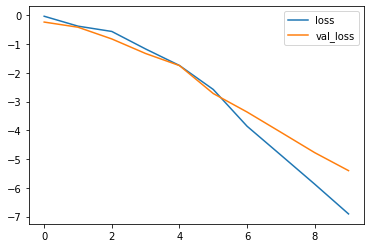

In [20]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

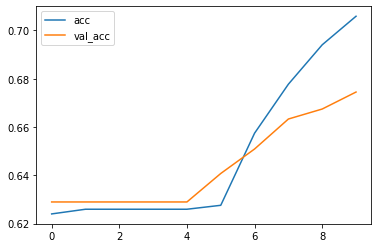

In [21]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()